# Installs & Imports

In [1]:
!pip install -q torch transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import torch
print(torch.__version__)

2.2.1+cu121


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import random
import math
from collections import Counter
from tqdm.notebook import tqdm

import logging
from transformers import logging as transformers_logging

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import Variable

from transformers import get_linear_schedule_with_warmup
import datasets
from datasets import load_dataset

from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)

transformers_logging.set_verbosity_error()

Using device: cuda


# Loading the Data

In [5]:
# Download and load the CNN/Daily Mail dataset
train_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")
val_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
# Get dataset information
def get_dataset_info(dataset):
    length = len(dataset)
    print(f"Dataset length: {length}")

    num_articles = len(dataset["article"])
    print(f"Number of articles: {num_articles}")

    num_highlights = len(dataset["highlights"])
    print(f"Number of highlights: {num_highlights}")

    dataset_type = type(dataset)
    print(f"Dataset type: {dataset_type}")

In [7]:
# Get basic dataset information
print("Train Dataset:")
get_dataset_info(train_dataset)

print("\nValidation Dataset:")
get_dataset_info(val_dataset)

print("\nTest Dataset:")
get_dataset_info(test_dataset)

Train Dataset:
Dataset length: 287113
Number of articles: 287113
Number of highlights: 287113
Dataset type: <class 'datasets.arrow_dataset.Dataset'>

Validation Dataset:
Dataset length: 13368
Number of articles: 13368
Number of highlights: 13368
Dataset type: <class 'datasets.arrow_dataset.Dataset'>

Test Dataset:
Dataset length: 11490
Number of articles: 11490
Number of highlights: 11490
Dataset type: <class 'datasets.arrow_dataset.Dataset'>


In [8]:
def examine_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        sample = dataset[i]
        print(f"Article {i+1}: {sample['article']}\n")
        print(f"Highlights {i+1}: {sample['highlights']}\n")
        print("*" * 150)

In [9]:
# Examine dataset contents
print("Train Dataset:")
examine_dataset(train_dataset)

print("\nValidation Dataset:")
examine_dataset(val_dataset)

print("\nTest Dataset:")
examine_dataset(test_dataset)

Train Dataset:
Article 1: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box of

# Preprocessing the Data

In [10]:
# Create a custom vocabulary
def build_vocabulary(datasets, max_vocab_size=30000, special_tokens=None):
    if special_tokens is None:
        special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']

    vocab = Counter()
    total_examples = sum(len(dataset) for dataset in datasets)

    with tqdm(total=total_examples, desc="Building vocabulary") as pbar:
        for dataset in datasets:
            for example in dataset:
                vocab.update(example['article'].split())
                vocab.update(example['highlights'].split())
                pbar.update(1)

    vocab_list = [word for word, _ in vocab.most_common(max_vocab_size - len(special_tokens))]
    vocab_dict = {token: idx + len(special_tokens) for idx, token in enumerate(vocab_list)}

    for idx, special_token in enumerate(special_tokens):
        vocab_dict[special_token] = idx

    return vocab_dict

vocab = build_vocabulary([train_dataset, val_dataset, test_dataset], max_vocab_size=30000)

Building vocabulary:   0%|          | 0/311971 [00:00<?, ?it/s]

In [11]:
def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in text.split()]

def preprocess_function(batch, vocab, max_input_length, max_target_length):
    input_ids = []
    source_masks = []
    labels = []
    decoder_input_ids = []
    target_masks = []

    for article, highlights in zip(batch['article'], batch['highlights']):
        # Convert input text to integer sequence
        input_id = text_to_sequence(article, vocab)
        if len(input_id) < max_input_length:
            input_id = input_id + [vocab['<pad>']] * (max_input_length - len(input_id))
        input_id = input_id[:max_input_length]
        input_ids.append(torch.tensor(input_id))

        # Create source attention mask
        source_mask = [1] * len(input_id) + [0] * (max_input_length - len(input_id))
        source_masks.append(torch.tensor(source_mask))

        # Convert target text to integer sequence
        label = text_to_sequence(highlights, vocab)
        if len(label) < max_target_length:
            label = label + [vocab['<pad>']] * (max_target_length - len(label))
        label = label[:max_target_length - 1]
        label.append(vocab['<eos>'])
        labels.append(torch.tensor(label))

        # Create decoder_input_ids by shifting the labels sequence to the right
        decoder_input_id = [vocab['<sos>']] + label[:-1]
        decoder_input_id = decoder_input_id[:max_target_length]
        decoder_input_ids.append(torch.tensor(decoder_input_id))

        # Create target attention mask
        target_mask = [1] * len(decoder_input_id) + [0] * (max_target_length - len(decoder_input_id))
        target_masks.append(torch.tensor(target_mask))

    return {
        'input_ids': input_ids,
        'source_mask': source_masks,
        'labels': labels,
        'decoder_input_ids': decoder_input_ids,
        'target_mask': target_masks
    }

In [12]:
# Preprocess the datasets
max_input_length = 512
max_target_length = 128

processed_train_dataset = train_dataset.map(
    lambda batch: preprocess_function(batch, vocab, max_input_length, max_target_length),
    batched=True,
    batch_size=1000,
    remove_columns=train_dataset.column_names
)
processed_val_dataset = val_dataset.map(
    lambda batch: preprocess_function(batch, vocab, max_input_length, max_target_length),
    batched=True,
    batch_size=1000,
    remove_columns=val_dataset.column_names
)
processed_test_dataset = test_dataset.map(
    lambda batch: preprocess_function(batch, vocab, max_input_length, max_target_length),
    batched=True,
    batch_size=1000,
    remove_columns=test_dataset.column_names
)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [13]:
# Examine processed datasets
print("Processed Train Dataset:")
print(processed_train_dataset, "\n")
for key in processed_train_dataset[0]:
    print(f"{key}:")
    print(processed_train_dataset[0][key])
    print(f"Length of key:", len(processed_train_dataset[0][key]), "\n")

print("\nProcessed Validation Dataset:")
print(processed_val_dataset, "\n")
for key in processed_val_dataset[0]:
    print(f"{key}:")
    print(processed_val_dataset[0][key])
    print(f"Length of key:", len(processed_val_dataset[0][key]), "\n")

print("\nProcessed Test Dataset:")
print(processed_test_dataset, "\n")
for key in processed_test_dataset[0]:
    print(f"{key}:")
    print(processed_test_dataset[0][key])
    print(f"Length of key:", len(processed_test_dataset[0][key]), "\n")

Processed Train Dataset:
Dataset({
    features: ['input_ids', 'source_mask', 'labels', 'decoder_input_ids', 'target_mask'],
    num_rows: 287113
}) 

input_ids:
[13840, 276, 1, 69, 1408, 7883, 516, 1531, 19257, 8769, 936, 5, 7, 339, 12446, 210, 1, 10283, 5268, 21, 20, 3033, 747, 13, 1823, 42, 20, 2526, 4, 297, 1169, 2624, 7, 4155, 13, 574, 1531, 19257, 21, 1408, 7883, 9, 1, 7883, 8, 4, 11178, 6, 4, 1, 914, 4, 8577, 6, 16731, 1, 124, 4, 1838, 4, 218, 1861, 110, 20, 24, 86, 635, 5, 1, 18, 1528, 215, 13, 2195, 6881, 1847, 8, 2778, 11081, 260, 200, 785, 5, 26, 51, 6, 137, 64, 6405, 21, 750, 21, 40, 773, 2908, 3076, 1046, 878, 7, 1404, 1697, 233, 1609, 50, 275, 1, 20, 66, 31, 803, 24493, 429, 44, 1456, 260, 200, 149, 3214, 26, 1122, 1, 332, 425, 35, 91, 2518, 29, 425, 14, 650, 47, 283, 2080, 69, 2523, 8, 1, 8, 1, 344, 2908, 19257, 43, 26, 257, 5, 19623, 9, 7, 1, 1046, 7, 1847, 9, 7, 3777, 50, 145, 4, 4593, 678, 1, 7141, 1, 594, 245, 1724, 1824, 18, 217, 51, 1579, 13, 4, 393, 1797, 662, 1, 

In [14]:
# Convert HuggingFace dataset to PyTorch dataset
processed_train_dataset.set_format(type='torch', columns=['input_ids', 'source_mask', 'labels', 'decoder_input_ids', 'target_mask'])
processed_val_dataset.set_format(type='torch', columns=['input_ids', 'source_mask', 'labels', 'decoder_input_ids', 'target_mask'])
processed_test_dataset.set_format(type='torch', columns=['input_ids', 'source_mask', 'labels', 'decoder_input_ids', 'target_mask'])

In [15]:
# Create random subsets of the data
subset_size = 50000
subset_scale_factor = 0.2

shuffled_train_dataset = processed_train_dataset.shuffle(seed=42)
shuffled_val_dataset = processed_val_dataset.shuffle(seed=42)
shuffled_test_dataset = processed_test_dataset.shuffle(seed=42)

train_subset = shuffled_train_dataset.select(range(subset_size))
val_subset = shuffled_val_dataset.select(range(int(subset_size * subset_scale_factor)))
test_subset = shuffled_test_dataset.select(range(int(subset_size * subset_scale_factor)))

In [16]:
# Create DataLoaders
batch_size = 32

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, drop_last=True)

In [17]:
# Examine the DataLoaders
print("Training Data Loader:")
batch_train = next(iter(train_dataloader))
for key in batch_train:
    print(f"{key}: {batch_train[key].shape}")
    print(batch_train[key])
print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataloader) * batch_size}")

print("\nValidation Data Loader:")
batch_val = next(iter(val_dataloader))
for key in batch_val:
    print(f"{key}: {batch_val[key].shape}")
    print(batch_val[key])
print(f"Number of batches: {len(val_dataloader)}")
print(f"Number of samples: {len(val_dataloader) * batch_size}")

print("\nTest Data Loader:")
batch_test = next(iter(test_dataloader))
for key in batch_test:
    print(f"{key}: {batch_test[key].shape}")
    print(batch_test[key])
print(f"Number of batches: {len(test_dataloader)}")
print(f"Number of samples: {len(test_dataloader) * batch_size}")

Training Data Loader:
input_ids: torch.Size([32, 512])
tensor([[  159,    10, 11001,  ...,     7, 14163,    23],
        [  251,    69,  9357,  ...,   185,    53,     9],
        [  159,    10,  9908,  ...,  2195,   291,  1064],
        ...,
        [  159,    10, 24762,  ...,   116,     6,     4],
        [  159,    10, 10086,  ...,     0,     0,     0],
        [  201,     9,     1,  ...,    99,     1,    14]])
source_mask: torch.Size([32, 512])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
labels: torch.Size([32, 128])
tensor([[1115,    1,   11,  ...,    0,    0,    3],
        [ 133, 5395,  660,  ...,    0,    0,    3],
        [   1,  184,    5,  ...,    0,    0,    3],
        ...,
        [   1, 2509, 5380,  ...,    0,    0,    3],
        [   1,  705,    9,  ...,    0,    0,    3],
        [   1,   11, 2215, 

# Creating the Model

In [18]:
# GEGLU activation
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

In [19]:
# Embedding the input sequence
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

In [20]:
# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        x = x + pe
        x = self.dropout(x)
        return x

In [21]:
# Iterative Shrinkage-Thresholding Algorithm (ISTA) Layer
class ISTALayer(nn.Module):
    def __init__(self, embedding_dim, threshold=0.1, num_iterations=1, dropout=0.1):
        super(ISTALayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.num_iterations = num_iterations
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        residual = x
        for _ in range(self.num_iterations):
            x = self.norm(x)
            x = self.linear(x)
            x = torch.sign(x) * torch.max(torch.abs(x) - self.threshold, torch.zeros_like(x))
            x = self.dropout(x)
        x = residual + x
        return x

In [22]:
# Self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [23]:
# Encoder-decoder attention layer
class EncoderDecoderAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(EncoderDecoderAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [24]:
# Multi-head self-attention layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1, ista_threshold=0.1, ista_num_iterations=1):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.ista_layer = ISTALayer(embedding_dim, threshold=ista_threshold, num_iterations=ista_num_iterations, dropout=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.self_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        output = self.ista_layer(output)
        return output

In [25]:
# Multi-head encoder-decoder attention layer
class MultiHeadEncoderDecoderAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1, ista_threshold=0.1, ista_num_iterations=1):
        super(MultiHeadEncoderDecoderAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder_decoder_attention = EncoderDecoderAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.ista_layer = ISTALayer(embedding_dim, threshold=ista_threshold, num_iterations=ista_num_iterations, dropout=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.encoder_decoder_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        output = self.ista_layer(output)
        return output

In [26]:
# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)

In [27]:
# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

In [28]:
# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadEncoderDecoderAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

In [29]:
# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        x = self.embedding(source)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, source_mask)
        x = self.norm(x)
        return x

In [30]:
# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        x = self.embedding(target)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        x = self.norm(x)
        return x

In [31]:
# ISTA Transformer
class ISTATransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(ISTATransformer, self).__init__()
        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        memory = self.encoder(source, source_mask)
        output = self.decoder(target, memory, source_mask, target_mask)
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

In [18]:
# Define the model parameters
source_vocab_size = target_vocab_size = len(vocab)
source_max_seq_len = 512
target_max_seq_len = 128
embedding_dim = 512
num_heads = 8
num_layers = 6
dropout_rate = 0.3

In [33]:
# Initialize the model
model = ISTATransformer(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_max_seq_len=source_max_seq_len,
    target_max_seq_len=target_max_seq_len,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout_rate
)
model.to(device)

ISTATransformer(
  (encoder): Encoder(
    (embedding): Embedding(30000, 512)
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attention): MultiHeadSelfAttention(
          (self_attention): SelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
          (ista_layer): ISTALayer(
            (dropout): Dropout(p=0.3, inplace=False)
            (linear): Linear(in_features=512, out_features=512, bias=False)
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
        )
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_

# Training the Model

In [19]:
def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate, weight_decay, warmup_steps, device, patience=3, gradient_accumulation_steps=4, max_grad_norm=1.0):
    model.train()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs // gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    scaler = GradScaler()
    best_val_loss = float('inf')
    best_model_state_dict = None
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training")

        for batch_idx, batch in enumerate(train_progress_bar):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)
            source_mask = batch['source_mask'].to(device)
            target_mask = batch['target_mask'].to(device)

            optimizer.zero_grad()

            with autocast():
                logits = model(input_ids, decoder_input_ids, source_mask, target_mask)
                loss_fn = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
                loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1)) / gradient_accumulation_steps

            scaler.scale(loss).backward()
            train_loss += loss.item()

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                old_scaler = scaler.get_scale()
                scaler.step(optimizer)
                scaler.update()
                new_scaler = scaler.get_scale()

                if old_scaler <= new_scaler:
                    scheduler.step()

                optimizer.zero_grad()

            train_progress_bar.set_postfix({'loss': loss.item()})
            torch.cuda.empty_cache()

        model.eval()
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation")

            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                decoder_input_ids = batch['decoder_input_ids'].to(device)
                source_mask = batch['source_mask'].to(device)
                target_mask = batch['target_mask'].to(device)

                logits = model(input_ids, decoder_input_ids, source_mask, target_mask)
                loss_fn = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
                loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

                val_loss += loss.item()
                val_progress_bar.set_postfix({'loss': loss.item()})
                torch.cuda.empty_cache()

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            tqdm.write(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    model.load_state_dict(best_model_state_dict)

    return model, train_losses, val_losses

In [20]:
# Set the training parameters
epochs = 30
learning_rate = 0.005
weight_decay = 0.05
warmup_steps = 1000
patience = 5
gradient_accumulation_steps = 4
max_grad_norm = 1.0

In [36]:
# Initialize the training loop
trained_model, train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    device=device,
    patience=patience,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm
)

Epoch 1 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.4110, Val Loss: 8.3994


Epoch 2 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 2.1332, Val Loss: 8.6184


Epoch 3 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 2.3223, Val Loss: 10.0161


Epoch 4 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.5498, Val Loss: 10.2324


Epoch 5 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 2.5577, Val Loss: 10.2334


Epoch 6 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 2.5577, Val Loss: 10.2331
Early stopping triggered at epoch 6. Best validation loss: 8.3994


In [21]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
    ax.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='orange')

    ax.set_title('Training and Validation Losses', fontsize=16, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0.5, len(train_losses) + 0.5)
    ax.set_ylim(0, max(max(train_losses), max(val_losses)) * 1.1)

    # Add annotations for minimum validation loss
    min_val_loss_epoch = val_losses.index(min(val_losses)) + 1
    min_val_loss = min(val_losses)
    ax.annotate(f'Min Val Loss: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch + 0.5, min_val_loss * 1.05),
                fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red'))

    # Add annotations for training loss at the epoch with minimum validation loss
    train_loss_at_min_val_loss = train_losses[min_val_loss_epoch - 1]
    ax.annotate(f'Train Loss: {train_loss_at_min_val_loss:.4f}', xy=(min_val_loss_epoch, train_loss_at_min_val_loss),
                xytext=(min_val_loss_epoch, train_loss_at_min_val_loss * 1.2),
                textcoords='data', fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red'))

    fig.suptitle('Model Training Progress', fontsize=18, fontweight='bold')
    plt.tight_layout(pad=2.0)
    plt.show()

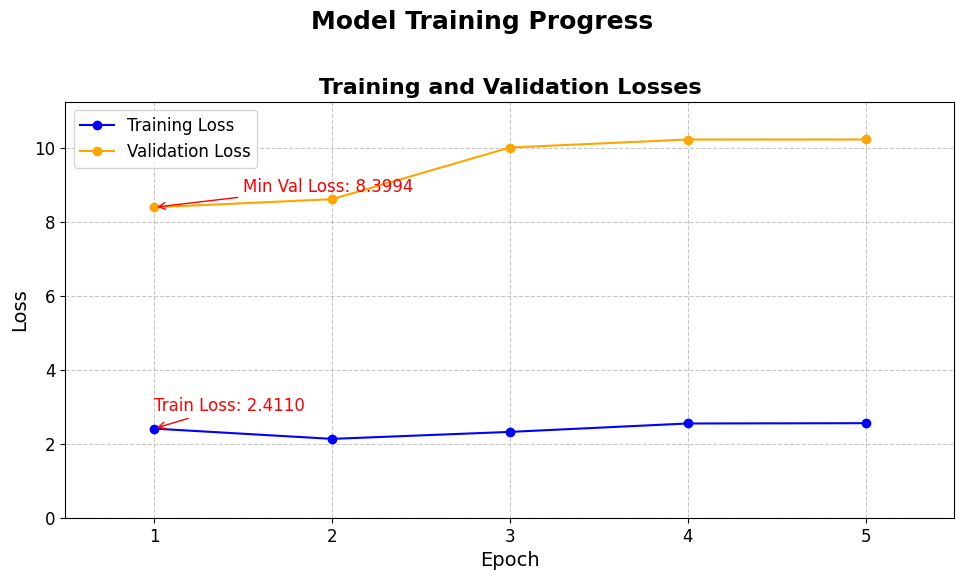

In [38]:
# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluating the Model

In [22]:
def evaluate_loss(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Loss"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)
            source_mask = batch['source_mask'].to(device)
            target_mask = batch['target_mask'].to(device)

            logits = model(input_ids, decoder_input_ids, source_mask, target_mask)
            loss_fn = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss

In [40]:
# Evaluate on the test set
evaluate_loss(trained_model, test_dataloader, device)

Evaluating Loss:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 10.2327


10.232651514884752

Model failure:
- The loss is high for training and validation
- Enforcing further sparsity may have led to too much information loss

Modifications implemented:
- Trained embeddings rather than using BERT tokenized data
- Applied ISTA layers to attention output rather than decoder output
- More customized architecture implementation

Directions for improvement:
- Apply ISTA in alternative areas, perhaps before the attention mechanism or within the feedforward networks

# Model Reconfiguration

In [23]:
# GEGLU activation
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

In [24]:
# Embedding the input sequence
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

In [25]:
# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**(2*i/embedding_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        x = x + pe
        x = self.dropout(x)
        return x

In [26]:
# Iterative Shrinkage-Thresholding Algorithm (ISTA) Layer
class ISTALayer(nn.Module):
    def __init__(self, embedding_dim, threshold=0.1, num_iterations=1, dropout=0.1):
        super(ISTALayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.num_iterations = num_iterations
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        residual = x
        for _ in range(self.num_iterations):
            x = self.norm(x)
            x = self.linear(x)
            x = torch.sign(x) * torch.max(torch.abs(x) - self.threshold, torch.zeros_like(x))
            x = self.dropout(x)
            x = residual + x
        return x

In [27]:
# Self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [28]:
# Encoder-decoder attention layer
class EncoderDecoderAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(EncoderDecoderAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [29]:
# Multi-head self-attention layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.self_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [30]:
# Multi-head encoder-decoder attention layer
class MultiHeadEncoderDecoderAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadEncoderDecoderAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder_decoder_attention = EncoderDecoderAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.encoder_decoder_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [31]:
# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)

In [32]:
# Transformer encoder layer with ISTA in feedforward network
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            *[ISTALayer(ff_dim // 2, threshold=ista_threshold, num_iterations=ista_num_iterations, dropout=dropout) for _ in range(num_ista_layers)],
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

In [33]:
# Transformer decoder layer with ISTA in feedforward network
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadEncoderDecoderAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            *[ISTALayer(ff_dim // 2, threshold=ista_threshold, num_iterations=ista_num_iterations, dropout=dropout) for _ in range(num_ista_layers)],
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

In [34]:
# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout, num_ista_layers, ista_threshold, ista_num_iterations) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        x = self.embedding(source)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, source_mask)
        x = self.norm(x)
        return x

In [35]:
# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout, num_ista_layers, ista_threshold, ista_num_iterations) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        x = self.embedding(target)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        x = self.norm(x)
        return x

In [36]:
# ISTA Transformer
class ISTATransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(ISTATransformer, self).__init__()
        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout, num_ista_layers, ista_threshold, ista_num_iterations)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout, num_ista_layers, ista_threshold, ista_num_iterations)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        memory = self.encoder(source, source_mask)
        output = self.decoder(target, memory, source_mask, target_mask)
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

In [37]:
# Define the model parameters
source_vocab_size = target_vocab_size = len(vocab)
source_max_seq_len = 512
target_max_seq_len = 128
embedding_dim = 512
num_heads = 8
num_layers = 6
dropout_rate = 0.3
num_ista_layers = 1
ista_threshold = 0.1
ista_num_iterations = 1

In [38]:
# Initialize the model
model = ISTATransformer(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_max_seq_len=source_max_seq_len,
    target_max_seq_len=target_max_seq_len,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout_rate,
    num_ista_layers=num_ista_layers,
    ista_threshold=ista_threshold,
    ista_num_iterations=ista_num_iterations
)
model.to(device)

ISTATransformer(
  (encoder): Encoder(
    (embedding): Embedding(
      (embedding): Embedding(30000, 512)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attention): MultiHeadSelfAttention(
          (self_attention): SelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GEGLU()
          (2): ISTALayer(
            (dropout): Dropout(p=0.3, inplace=False)
            (linear): Linear(in_features=1024, out_features=1024, bias=False)
        

In [39]:
# Initialize the training loop
trained_model, train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    device=device,
    patience=patience,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm
)

Epoch 1 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.5065, Val Loss: 9.5409


Epoch 2 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 2.4085, Val Loss: 9.7716


Epoch 3 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 2.5150, Val Loss: 10.2091


Epoch 4 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.5564, Val Loss: 10.2325


Epoch 5 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 2.5578, Val Loss: 10.2339


Epoch 6 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 2.5577, Val Loss: 10.2333
Early stopping triggered at epoch 6. Best validation loss: 9.5409


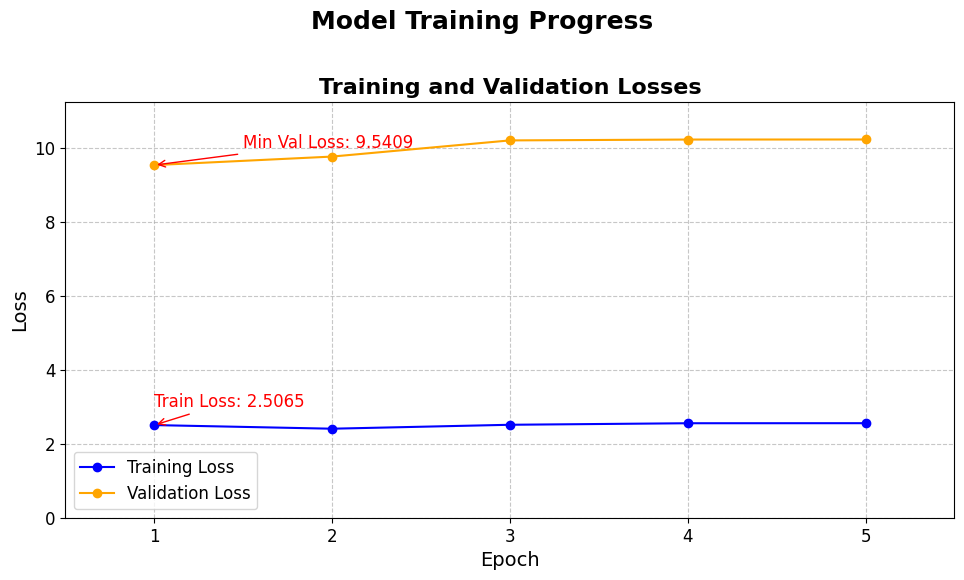

In [40]:
# Plot the losses
plot_losses(train_losses, val_losses)

In [41]:
# Evaluate on the test set
evaluate_loss(trained_model, test_dataloader, device)

Evaluating Loss:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 10.2329


10.232855274127079

Model failure:
- Placing ISTA layers within the feedforward networks resulted in high training and validation losses
- ISTA and additional sparsity more generally may not be useful for this model architecture

# Reconfiguration Retry

In [42]:
# GEGLU activation
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

In [43]:
# Embedding the input sequence with ISTA
class ISTAEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1, dropout=0.1):
        super(ISTAEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.ista_layers = nn.ModuleList([ISTALayer(embedding_dim, threshold=ista_threshold, num_iterations=ista_num_iterations, dropout=dropout) for _ in range(num_ista_layers)])

    def forward(self, x):
        x = self.embedding(x)
        for ista_layer in self.ista_layers:
            x = ista_layer(x)
        return x

In [44]:
# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**(2*i/embedding_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        x = x + pe
        x = self.dropout(x)
        return x

In [45]:
# Iterative Shrinkage-Thresholding Algorithm (ISTA) Layer
class ISTALayer(nn.Module):
    def __init__(self, embedding_dim, threshold=0.1, num_iterations=1, dropout=0.1):
        super(ISTALayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.num_iterations = num_iterations
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        residual = x
        for _ in range(self.num_iterations):
            x = self.norm(x)
            x = self.linear(x)
            x = torch.sign(x) * torch.max(torch.abs(x) - self.threshold, torch.zeros_like(x))
            x = self.dropout(x)
            x = residual + x
        return x

In [46]:
# Self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [47]:
# Encoder-decoder attention layer
class EncoderDecoderAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(EncoderDecoderAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [48]:
# Multi-head self-attention layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.self_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [49]:
# Multi-head encoder-decoder attention layer
class MultiHeadEncoderDecoderAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadEncoderDecoderAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder_decoder_attention = EncoderDecoderAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.encoder_decoder_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [50]:
# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)


In [51]:
# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

In [52]:
# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadEncoderDecoderAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

In [53]:
# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(Encoder, self).__init__()
        self.embedding = ISTAEmbedding(vocab_size, embedding_dim, num_ista_layers, ista_threshold, ista_num_iterations, dropout)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        x = self.embedding(source)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, source_mask)
        x = self.norm(x)
        return x

In [54]:
# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(Decoder, self).__init__()
        self.embedding = ISTAEmbedding(vocab_size, embedding_dim, num_ista_layers, ista_threshold, ista_num_iterations, dropout)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        x = self.embedding(target)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        x = self.norm(x)
        return x


In [55]:
# ISTA Transformer
class ISTATransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1, num_ista_layers=1, ista_threshold=0.1, ista_num_iterations=1):
        super(ISTATransformer, self).__init__()
        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout, num_ista_layers, ista_threshold, ista_num_iterations)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout, num_ista_layers, ista_threshold, ista_num_iterations)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        memory = self.encoder(source, source_mask)
        output = self.decoder(target, memory, source_mask, target_mask)
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

In [56]:
# Define the model parameters
source_vocab_size = target_vocab_size = len(vocab)
source_max_seq_len = 512
target_max_seq_len = 128
embedding_dim = 512
num_heads = 8
num_layers = 6
dropout_rate = 0.3
num_ista_layers = 1
ista_threshold = 0.1
ista_num_iterations = 1

In [57]:
# Initialize the model
model = ISTATransformer(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_max_seq_len=source_max_seq_len,
    target_max_seq_len=target_max_seq_len,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout_rate,
    num_ista_layers=num_ista_layers,
    ista_threshold=ista_threshold,
    ista_num_iterations=ista_num_iterations
)
model.to(device)

ISTATransformer(
  (encoder): Encoder(
    (embedding): ISTAEmbedding(
      (embedding): Embedding(30000, 512)
      (ista_layers): ModuleList(
        (0): ISTALayer(
          (dropout): Dropout(p=0.3, inplace=False)
          (linear): Linear(in_features=512, out_features=512, bias=False)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attention): MultiHeadSelfAttention(
          (self_attention): SelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_for

In [58]:
# Initialize the training loop
trained_model, train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    device=device,
    patience=patience,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm
)

Epoch 1 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.4900, Val Loss: 9.2466


Epoch 2 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 2.3133, Val Loss: 9.4009


Epoch 3 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 2.4629, Val Loss: 10.1758


Epoch 4 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.5550, Val Loss: 10.2338


Epoch 5 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 2.5578, Val Loss: 10.2335


Epoch 6 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 2.5578, Val Loss: 10.2324
Early stopping triggered at epoch 6. Best validation loss: 9.2466


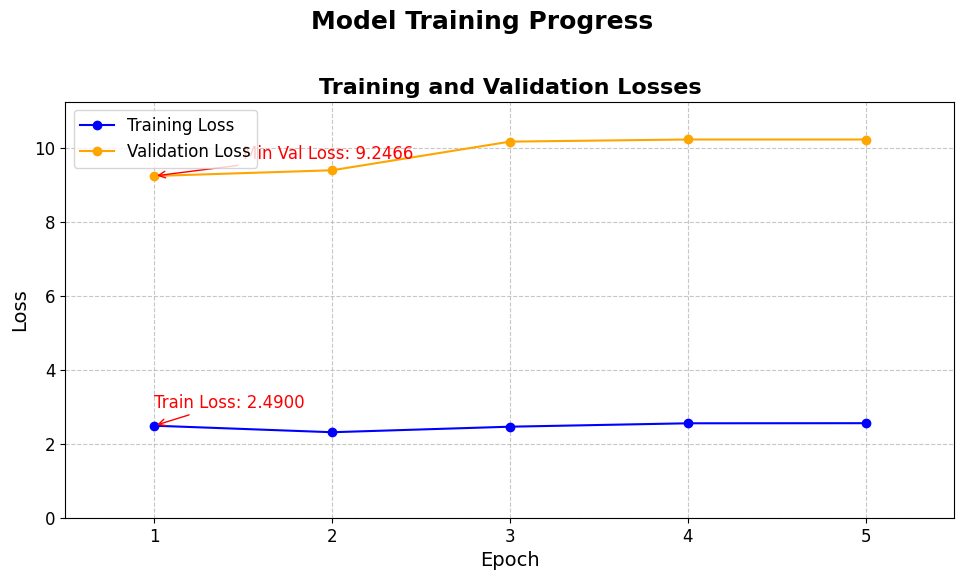

In [59]:
# Plot the losses
plot_losses(train_losses, val_losses)

In [60]:
# Evaluate on the test set
evaluate_loss(trained_model, test_dataloader, device)

Evaluating Loss:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 10.2319


10.231904946840727

Model Failure:
- Still high training and validation loss

# LISTA Investigation

In [80]:
# GEGLU activation
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

In [81]:
# Embedding the input sequence with LISTA
class LISTAEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_lista_layers=1, lista_num_iterations=1, dropout=0.1):
        super(LISTAEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lista_layers = nn.ModuleList([LISTALayer(embedding_dim, num_iterations=lista_num_iterations, dropout=dropout) for _ in range(num_lista_layers)])

    def forward(self, x):
        x = self.embedding(x)
        for lista_layer in self.lista_layers:
            x = lista_layer(x)
        return x

In [63]:
# Learned Iterative Shrinkage-Thresholding Algorithm (LISTA) Layer
class LISTALayer(nn.Module):
    def __init__(self, embedding_dim, num_iterations=1, dropout=0.1):
        super(LISTALayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_iterations = num_iterations
        self.dropout = nn.Dropout(dropout)
        self.theta = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.gamma = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, x):
        residual = x
        for _ in range(self.num_iterations):
            x = torch.sign(x) * torch.max(torch.abs(x) - self.gamma * self.beta, torch.zeros_like(x))
            x = self.theta(x)
            x = self.dropout(x)
            x = residual + x
        return x

In [64]:
# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (2 * i / embedding_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * i / embedding_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        x = x + pe
        x = self.dropout(x)
        return x

In [65]:
# Self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [66]:
# Encoder-decoder attention layer
class EncoderDecoderAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(EncoderDecoderAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e4)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)
        return output

In [67]:
# Multi-head self-attention layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.self_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [68]:
# Multi-head encoder-decoder attention layer
class MultiHeadEncoderDecoderAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadEncoderDecoderAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder_decoder_attention = EncoderDecoderAttention(dropout)
        self.num_heads = num_heads
        self.dim_per_head = embedding_dim // num_heads
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        scores = self.encoder_decoder_attention(query, key, value, mask)
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        output = self.out(output)
        return output

In [69]:
# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)

In [70]:
# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

In [71]:
# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadEncoderDecoderAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            GEGLU(),
            nn.Linear(ff_dim // 2, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

In [72]:
# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_lista_layers=1, lista_num_iterations=1):
        super(Encoder, self).__init__()
        self.embedding = LISTAEmbedding(vocab_size, embedding_dim, num_lista_layers, lista_num_iterations, dropout)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        x = self.embedding(source)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, source_mask)
        x = self.norm(x)
        return x

In [73]:
# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1, num_lista_layers=1, lista_num_iterations=1):
        super(Decoder, self).__init__()
        self.embedding = LISTAEmbedding(vocab_size, embedding_dim, num_lista_layers, lista_num_iterations, dropout)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        x = self.embedding(target)
        x = self.position_embedding(x)
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        x = self.norm(x)
        return x

In [74]:
# LISTA Transformer
class LISTATransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1, num_lista_layers=1, lista_num_iterations=1):
        super(LISTATransformer, self).__init__()
        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout, num_lista_layers, lista_num_iterations)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout, num_lista_layers, lista_num_iterations)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        memory = self.encoder(source, source_mask)
        output = self.decoder(target, memory, source_mask, target_mask)
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

In [75]:
# Define the model parameters
source_vocab_size = target_vocab_size = len(vocab)
source_max_seq_len = 512
target_max_seq_len = 128
embedding_dim = 512
num_heads = 8
num_layers = 6
dropout_rate = 0.3
num_lista_layers = 1
lista_num_iterations = 1

In [76]:
# Initialize the model
model = LISTATransformer(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_max_seq_len=source_max_seq_len,
    target_max_seq_len=target_max_seq_len,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout_rate,
    num_lista_layers=num_lista_layers,
    lista_num_iterations=lista_num_iterations
)
model.to(device)

LISTATransformer(
  (encoder): Encoder(
    (embedding): LISTAEmbedding(
      (embedding): Embedding(30000, 512)
      (lista_layers): ModuleList(
        (0): LISTALayer(
          (dropout): Dropout(p=0.3, inplace=False)
          (theta): Linear(in_features=512, out_features=512, bias=False)
        )
      )
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attention): MultiHeadSelfAttention(
          (self_attention): SelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_feature

In [77]:
# Initialize the training loop
trained_model, train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    device=device,
    patience=patience,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm
)

Epoch 1 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.5047, Val Loss: 9.5263


Epoch 2 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 2.3999, Val Loss: 9.7094


Epoch 3 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 2.5073, Val Loss: 10.2088


Epoch 4 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.5564, Val Loss: 10.2326


Epoch 5 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 2.5578, Val Loss: 10.2335


Epoch 6 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 2.5578, Val Loss: 10.2326
Early stopping triggered at epoch 6. Best validation loss: 9.5263


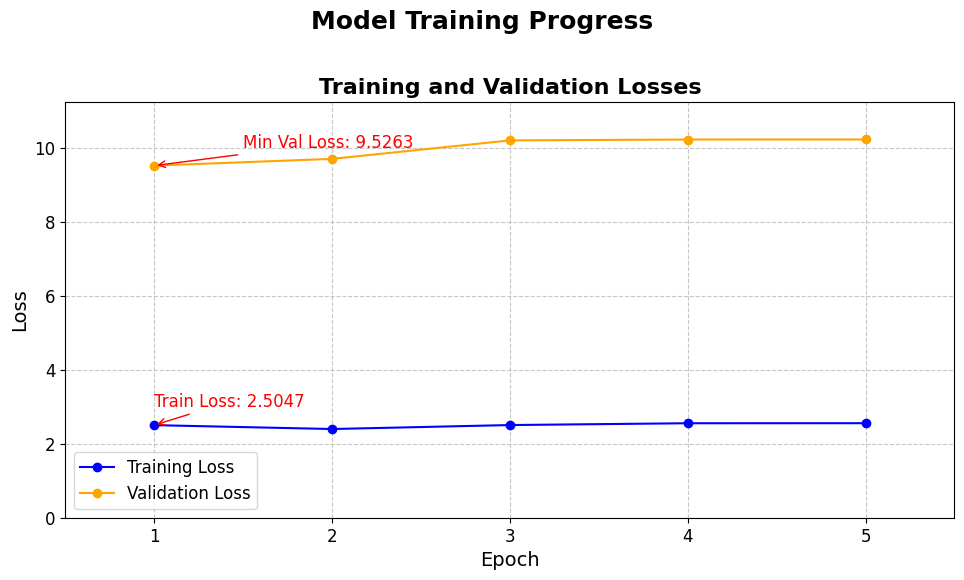

In [82]:
# Plot the losses
plot_losses(train_losses, val_losses)

In [79]:
# Evaluate on the test set
evaluate_loss(trained_model, test_dataloader, device)

Evaluating Loss:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 10.2322


10.232151651993776

Model failure:
- LISTA reconfiguration did not yield any improvements
- ISTA and its variants are mainly used for continuous-domain problems. Algorithms more suited to high-dimensional discrete data, which is what tokens are, or specifically empirically tested on text-based problems should be investigated for deep unrolling within transformer-based architectures.